In [6]:
"""This code is for getting data on the performance of different entity generation methods."""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt
from wikification import *
import os
import json


def generateCandidates1(textData, maxC, oText):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase.
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = getMentionSentence(oText, mention)
        context = escapeStringSolr(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
                
        # sort by frequency
        solrRes = sorted(solrRes, key = itemgetter(1), reverse = True)
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

def generateCandidates2(textData, maxC):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase (most frequent).
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    candidates = []
    
    for mention in textData['mentions']:
        results = sorted(anchor2concept(textData['text'][mention[0]]), key = itemgetter(1), 
                          reverse = True)
        candidates.append(results[:maxC]) # take up to maxC of the results
    
    return candidates

def generateCandidates3(textData, maxC):
    
    candidates = []
    
    for mention in textData['mentions']:
        anchors = anchor2concept(textData['text'][mention[0]])
        entities = []
        
        for anchor in anchors:
            wanchors = id2anchor(anchor[0]) # get all anchors of the id in this anchor
            totalFreq = 0
            for wanchor in wanchors:
                totalFreq += wanchor[1]
            
            entities.append([anchor[0], totalFreq])
        
        results = sorted(entities, key = itemgetter(1), reverse = True)
        
        candidates.append(results[:maxC]) # take up to maxC of the results
    
    return candidates

def generateCandidates5(textData, maxC):
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = []
        
        for mention2 in textData['mentions']:
            if mention2 <> mention:
                context += escapeStringSolr(textData['text'][mention2[0]])
        context = " ".join(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 20
correctCands1 = {} # dictionary containing the amount of correct entities found at each index
correctCands2 = {} # dictionary containing the amount of correct entities found at each index
correctCands3 = {} # dictionary containing the amount of correct entities found at each index
correctCands4 = {} # dictionary containing the amount of correct entities found at each index
correctCands5 = {} # dictionary containing the amount of correct entities found at each index
for i in range(-1, maxC):
    correctCands1[str(i)] = 0
    correctCands2[str(i)] = 0
    correctCands3[str(i)] = 0
    correctCands4[str(i)] = 0
    correctCands5[str(i)] = 0

totalMentions = 0

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    #print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        oText = " ".join(line['text'])
            
        cands1 = generateCandidates1(line, maxC, oText)
        cands2 = generateCandidates2(line, maxC)
        cands3 = generateCandidates3(line, maxC)
        cands4 = []
        for cands in cands1:
            cands4.append(sorted(cands, key = itemgetter(2), reverse = True))
        cands5 = generateCandidates5(line, maxC)
        
        i = 0
        for cand in cands1:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands1[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands1['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands2:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands2[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands2['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands3:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands3[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands3['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands4:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands4[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands4['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands5:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands5[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands5['-1'] += 1
            i += 1
            
            
        totalLines += 1
        
clear_output()

Total Mentions: 27092


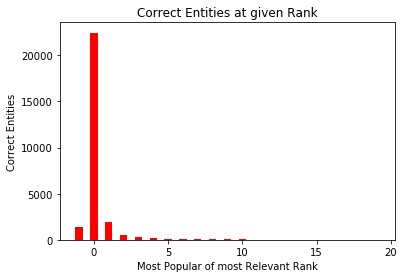

Misplaced: 1335
[1335, 22453, 1899, 542, 290, 165, 106, 67, 50, 37, 35, 43, 20, 13, 14, 6, 9, 3, 2, 1, 2]




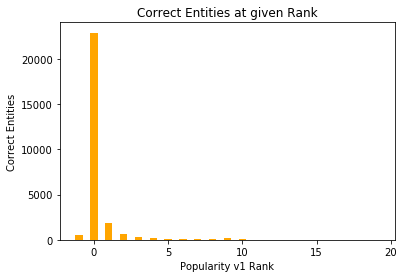

Misplaced: 532
[532, 22896, 1823, 640, 312, 144, 123, 87, 99, 55, 152, 40, 30, 28, 28, 23, 22, 17, 18, 13, 10]




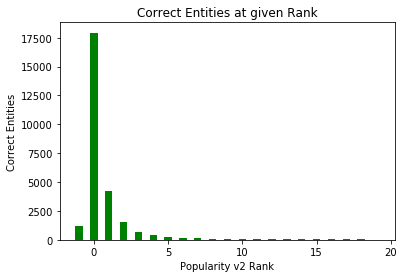

Misplaced: 1159
[1159, 17930, 4194, 1517, 666, 404, 225, 184, 179, 102, 103, 64, 51, 53, 61, 43, 35, 26, 47, 31, 18]




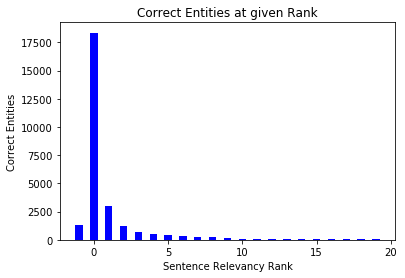

Misplaced: 1335
[1335, 18348, 2967, 1185, 713, 514, 420, 323, 239, 218, 151, 105, 96, 100, 56, 64, 57, 56, 58, 42, 45]




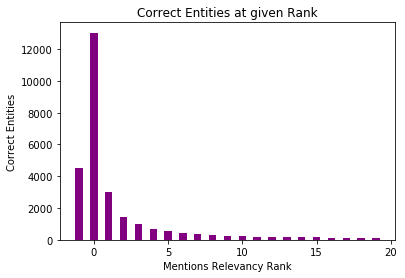

Misplaced: 4516
[4516, 13033, 2993, 1451, 972, 689, 547, 427, 392, 303, 270, 212, 189, 161, 152, 166, 152, 140, 125, 103, 99]




In [7]:
"""The graphs generated in this cell is for showing how many correct entities
are at each position of different candidate generation methods, as well as how 
many correct entities are not in the candidates."""

candsPopRel = []
for i in range(-1,maxC):
    candsPopRel.append(correctCands1[str(i)])
    
candsPop = []
for i in range(-1,maxC):
    candsPop.append(correctCands2[str(i)])
    
candsPopPop = []
for i in range(-1,maxC):
    candsPopPop.append(correctCands3[str(i)])
    
candsRelSentence = []
for i in range(-1,maxC):
    candsRelSentence.append(correctCands4[str(i)])
    
candsRelMentions = []
for i in range(-1,maxC):
    candsRelMentions.append(correctCands5[str(i)])
    
x = range(-1, maxC)

print 'Total Mentions: ' + str(totalMentions)


plt.bar(x, candsPopRel, 0.5, color='red')
plt.xlabel('Most Popular of most Relevant Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands1[str(-1)])
print str(candsPopRel) + '\n\n'


plt.bar(x, candsPop, 0.5, color='orange')
plt.xlabel('Popularity v1 Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands2[str(-1)])
print str(candsPop) + '\n\n'


plt.bar(x, candsPopPop, 0.5, color='green')
plt.xlabel('Popularity v2 Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands3[str(-1)])
print str(candsPopPop) + '\n\n'


plt.bar(x, candsRelSentence, 0.5, color='blue')
plt.xlabel('Sentence Relevancy Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands4[str(-1)])
print str(candsRelSentence) + '\n\n'


plt.bar(x, candsRelMentions, 0.5, color='purple')
plt.xlabel('Mentions Relevancy Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands5[str(-1)])
print str(candsRelMentions) + '\n\n'

In [17]:
"""This is to generate data for seeing the candidate generation quality on each separate dataset"""
from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt
from wikification import *
import os
import json

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 20

totalMntsKore = 0
totalMntsAquaint = 0
totalMntsMsnbc = 0
totalMntsWiki = 0

correctCandsKore = {} # dictionary containing the amount of correct entities found at each index
correctCandsAquaint = {} # dictionary containing the amount of correct entities found at each index
correctCandsMsnbc = {} # dictionary containing the amount of correct entities found at each index
correctCandsWiki = {} # dictionary containing the amount of correct entities found at each index
for i in range(-1, maxC):
    correctCandsKore[str(i)] = 0
    correctCandsAquaint[str(i)] = 0
    correctCandsMsnbc[str(i)] = 0
    correctCandsWiki[str(i)] = 0

totalMentions = 0

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    #print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        oText = " ".join(line['text'])
            
        cands = generateCandidates(line, maxC)
        
        i = 0
        for cand in cands:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    if dataset['name'] == 'kore':
                        correctCandsKore[str(j)] += 1
                    elif dataset['name'] == 'AQUAINT':
                        correctCandsAquaint[str(j)] += 1
                    elif dataset['name'] == 'MSNBC':
                        correctCandsMsnbc[str(j)] += 1
                    elif dataset['name'] == 'wiki5000':
                        correctCandsWiki[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                if dataset['name'] == 'kore':
                    correctCandsKore['-1'] += 1
                elif dataset['name'] == 'AQUAINT':
                    correctCandsAquaint['-1'] += 1
                elif dataset['name'] == 'MSNBC':
                    correctCandsMsnbc['-1'] += 1
                elif dataset['name'] == 'wiki5000':
                    correctCandsWiki['-1'] += 1
            i += 1
        
        totalLines += 1
    
    if dataset['name'] == 'kore':
        totalMntsKore = totalMentions
    elif dataset['name'] == 'AQUAINT':
        totalMntsAquaint = totalMentions
    elif dataset['name'] == 'MSNBC':
        totalMntsMsnbc = totalMentions
    elif dataset['name'] == 'wiki5000':
        totalMntsWiki = totalMentions
    
    totalMentions = 0
        
clear_output()

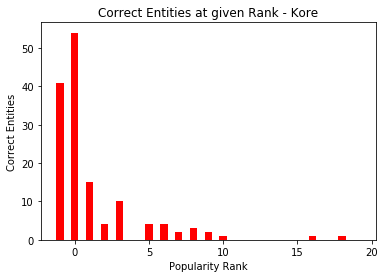

Kore Mentions: 142
Misplaced: 41
[41, 54, 15, 4, 10, 0, 4, 4, 2, 3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]




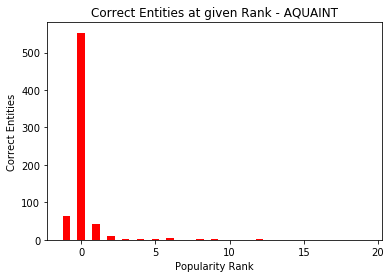

AQUAINT Mentions: 685
Misplaced: 63
[63, 553, 43, 9, 1, 2, 3, 5, 0, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]




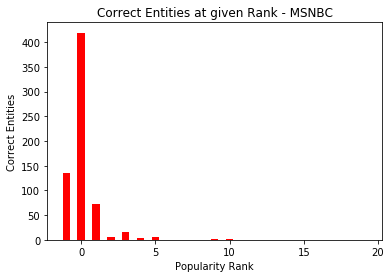

MSNBC Mentions: 657
Misplaced: 135
[135, 419, 72, 5, 15, 4, 5, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]




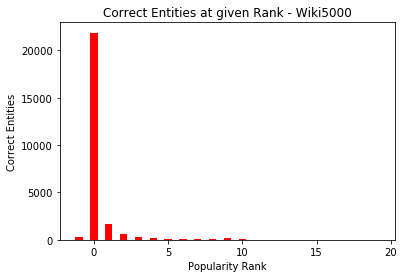

Wiki Mentions: 25608
Misplaced: 293
[293, 21870, 1693, 622, 286, 138, 111, 78, 97, 49, 147, 38, 30, 27, 28, 23, 22, 16, 18, 12, 10]




In [21]:
"""This is to visualize the candidate generation quality on each separate dataset"""

candsKore = []
for i in range(-1,maxC):
    candsKore.append(correctCandsKore[str(i)])

candsAquaint = []
for i in range(-1,maxC):
    candsAquaint.append(correctCandsAquaint[str(i)])
    
candsMsnbc = []
for i in range(-1,maxC):
    candsMsnbc.append(correctCandsMsnbc[str(i)])
    
candsWiki = []
for i in range(-1,maxC):
    candsWiki.append(correctCandsWiki[str(i)])
    
x = range(-1, maxC)

plt.bar(x, candsKore, 0.5, color='red')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Kore')
plt.show()
print 'Kore Mentions: ' + str(totalMntsKore)
print 'Misplaced: ' + str(correctCandsKore[str(-1)])
print str(candsKore) + '\n\n'

plt.bar(x, candsAquaint, 0.5, color='red')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - AQUAINT')
plt.show()
print 'AQUAINT Mentions: ' + str(totalMntsAquaint)
print 'Misplaced: ' + str(correctCandsAquaint[str(-1)])
print str(candsAquaint) + '\n\n'

plt.bar(x, candsMsnbc, 0.5, color='red')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - MSNBC')
plt.show()
print 'MSNBC Mentions: ' + str(totalMntsMsnbc)
print 'Misplaced: ' + str(correctCandsMsnbc[str(-1)])
print str(candsMsnbc) + '\n\n'

plt.bar(x, candsWiki, 0.5, color='red')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Wiki5000')
plt.show()
print 'Wiki Mentions: ' + str(totalMntsWiki)
print 'Misplaced: ' + str(correctCandsWiki[str(-1)])
print str(candsWiki) + '\n\n'

In [ ]:
"""These visualisations are to compare the amount of correct candidates contained in the top
candidates, as well as the amount of correct candidates contained in all of the candidates"""